In [3]:
from utils.dataset import TilesDatasetFly, TilesDataset
from towbintools.deep_learning.utils.augmentation import get_mean_and_std, get_training_augmentation, get_validation_augmentation, grayscale_to_rgb
import os

import pytorch_lightning as pl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from towbintools.deep_learning.utils.augmentation import get_validation_augmentation
from torchmetrics.classification import BinaryF1Score, Dice, JaccardIndex
import albumentations as albu
from towbintools.foundation import image_handling
from pytorch_toolbelt.inference import ImageSlicer, TileMerger
import pretrained_microscopy_models as pmm
from architectures import NestedUNet
import pytorch_toolbelt.losses as L
from utils.loss import FocalTverskyLoss
import skimage.io as skio
# database_csv = "/mnt/external.data/TowbinLab/plenart/20221020_Ti2_10x_green_bacteria_wbt150_small_chambers_good/analysis/report/analysis_filemap.csv"
database_path = "/mnt/external.data/TowbinLab/plenart/lifespan_08_09/all/"
images = sorted([os.path.join(database_path, f) for f in os.listdir(database_path)])
# image_column = 'raw'
# mask_column = 'analysis/ch2_seg'

# database = pd.read_csv(database_csv).dropna(subset=[mask_column])
# database = database.dropna(subset=[image_column])

# # pick 10000 random images
# database = database.sample(n=40000, random_state=42)
# training_dataframe, validation_dataframe = train_test_split(database, test_size=0.25, random_state=42)

In [4]:
class LightningPretrained(pl.LightningModule):
	def __init__(self, n_classes, learning_rate, architecture, encoder, pretrained_weights, normalization):
		super().__init__()
		self.model = pmm.segmentation_training.create_segmentation_model(
            architecture=architecture,
            encoder = encoder,
            encoder_weights=pretrained_weights,
            classes=1,
        )
		self.learning_rate = learning_rate
		self.criterion = FocalTverskyLoss()
		self.dice = Dice()
		self.f1_score = BinaryF1Score()
		self.normalization = normalization
		self.save_hyperparameters()

	def forward(self, x):
		return self.model(x)

	def log_tb_images(self, viz_batch) -> None:

		# Get tensorboard logger
		tb_logger = None
		for logger in self.trainer.loggers:
			if isinstance(logger, pl.loggers.TensorBoardLogger):
				tb_logger = logger.experiment
				break

		if tb_logger is None:
				raise ValueError('TensorBoard Logger not found')
		# # Log the images (Give them different names)
		# for img_idx, (image, y_true, y_pred) in enumerate(zip(*viz_batch)):
		# 	tb_logger.add_image(f"Image/{img_idx}", image_handling.normalize_image(image.cpu().numpy(), dest_dtype=np.float32), 0)
		# 	tb_logger.add_image(f"GroundTruth/{img_idx}", y_true*255, 0)
		# 	tb_logger.add_image(f"Prediction/{img_idx}", y_pred, 0)

	def training_step(self, batch, batch_idx):
		x, y = batch
		y_hat = self.model(x)
		loss = self.criterion(y_hat, y)
		self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)

		predicted = y_hat > 0.5
		dice_score = self.dice(predicted, y)
		self.log("train_dice", dice_score, on_step=False, on_epoch=True, logger=True, sync_dist=True)
		f1_score = self.f1_score(predicted, y)
		self.log("train_f1_score", f1_score, on_step=False, on_epoch=True, logger=True, sync_dist=True)

		return loss

	def validation_step(self, batch, batch_idx):
		x, y = batch
		y_hat = self.model(x)
		loss = self.criterion(y_hat, y)
		self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
		
		predicted = y_hat > 0.5
		
		dice_score = self.dice(predicted, y)
		self.log("val_dice", dice_score, on_step=True, on_epoch=True, logger=True, sync_dist=True)
		f1_score = self.f1_score(predicted, y)
		self.log("val_f1_score", f1_score, on_step=True, on_epoch=True, logger=True, sync_dist=True)

		# if batch_idx == 0:
		# 	self.log_tb_images((x, y, y_hat))

	def configure_optimizers(self):
		optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
		return optimizer
	
class LightningUnetPlusPlus(pl.LightningModule):
	def __init__(self, n_classes, learning_rate, normalization):
		super().__init__()
		model = NestedUNet(num_classes=1, input_channels=1, deep_supervision=False)
		self.model = model
		self.learning_rate = learning_rate
		self.criterion = L.BinaryFocalLoss()
		self.f1_score = BinaryF1Score()
		self.IoU = JaccardIndex(task='binary')
		self.normalization = normalization
		self.save_hyperparameters()

	def forward(self, x):
		return self.model(x)

	def log_tb_images(self, viz_batch) -> None:

		# Get tensorboard logger
		tb_logger = None
		for logger in self.trainer.loggers:
			if isinstance(logger, pl.loggers.TensorBoardLogger):
				tb_logger = logger.experiment
				break

		if tb_logger is None:
				raise ValueError('TensorBoard Logger not found')

	def training_step(self, batch, batch_idx):
		x, y = batch
		y_hat = self.model(x)
		loss = self.criterion(y_hat, y)
		self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)

		f1_score = self.f1_score(y_hat, y)
		self.log("train_f1_score", f1_score, on_step=False, on_epoch=True, logger=True, sync_dist=True)
		IoU = self.IoU(y_hat, y)
		self.log("train_IoU", IoU, on_step=False, on_epoch=True, logger=True, sync_dist=True)

		return loss

	def validation_step(self, batch, batch_idx):
		x, y = batch
		y_hat = self.model(x)
		loss = self.criterion(y_hat, y)
		self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
		
		f1_score = self.f1_score(y_hat, y)
		self.log("val_f1_score", f1_score, on_step=True, on_epoch=True, logger=True, sync_dist=True)
		IoU = self.IoU(y_hat, y)
		self.log("val_IoU", IoU, on_step=True, on_epoch=True, logger=True, sync_dist=True)

	def configure_optimizers(self):
		optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
		return optimizer

/mnt/external.data/TowbinLab/plenart/lifespan_08_09/all/0_100_BF.bmp
(2064, 3000)


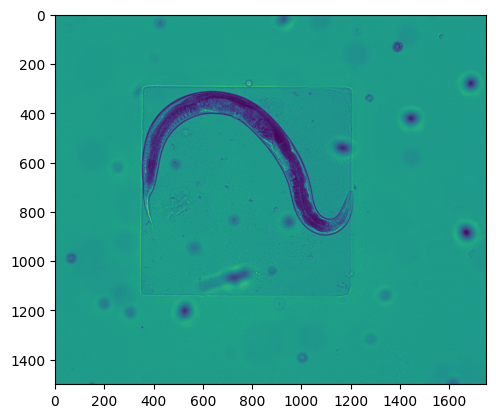

In [5]:
test_idx = 1
print(images[test_idx])

test_img = skio.imread(images[test_idx])
# test_img = validation_dataframe.iloc[test_idx][image_column]
# test_mask = validation_dataframe.iloc[test_idx][mask_column]

# test_img = image_handling.read_tiff_file(test_img, [2])
# test_mask = image_handling.read_tiff_file(test_mask)

print(test_img.shape)
test_img = test_img[250:1750, 750:2500]
plt.imshow(test_img)
plt.show()


# plt.imshow(test_mask)
# plt.show()

In [6]:
# model_path = "/home/spsalmon/towbintools/towbintools/deep_learning/unet_lightning_test/unetplusplus_no_pretrain_tversky.ckpt"
model_path = "/home/spsalmon/towbintools/towbintools/deep_learning/unet_confocal/epoch=102-step=16377.ckpt"
checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
model = LightningPretrained.load_from_checkpoint(model_path, map_location=torch.device('cpu'))
model.eval()
normalization_type = model.normalization['type']
normalization_params = model.normalization
augmentation = get_validation_augmentation(normalization_type=normalization_type, lo = normalization_params['lo'], hi = normalization_params['hi'])

print(model.hparams)

"architecture":       UnetPlusPlus
"encoder":            efficientnet-b4
"learning_rate":      1e-05
"n_classes":          1
"normalization":      {'type': 'percentile', 'lo': 1, 'hi': 99}
"pretrained_weights": image-micronet


In [7]:
tiler = ImageSlicer(test_img.shape, tile_size=(512, 512), tile_step=(256, 256), weight='pyramid')
test_img = augmentation(image=test_img)['image']
test_tiles = tiler.split(test_img)


pred_tiles = []
for tile in test_tiles:
    tile = grayscale_to_rgb(tile).unsqueeze(0)
    # tile = torch.tensor(tile[np.newaxis, ...]).unsqueeze(0)
    prediction = model(tile)
    # prediction = torch.sigmoid(prediction)
    prediction = prediction.squeeze(0).detach().numpy()
    prediction = np.moveaxis(prediction, 0, -1)
    pred_tiles.append(prediction)
    print(prediction.shape)

(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)


KeyboardInterrupt: 

In [ ]:
merged_pred = tiler.merge(pred_tiles)

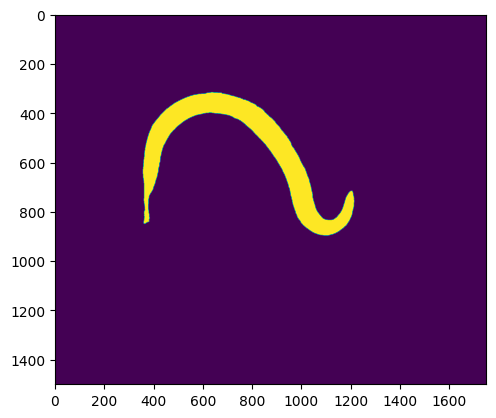

In [ ]:
plt.imshow(merged_pred>0.5)
plt.show()

/mnt/towbin.data/shared/ngerber/20230927_LIPSI_20x_348_297_20C_20230927_165930_303/pad2/raw/Time00177_Point0051_ChannelmCherry,GFP,BF,empty_Seq15986.ome.tiff
(17, 4, 1021, 1020)


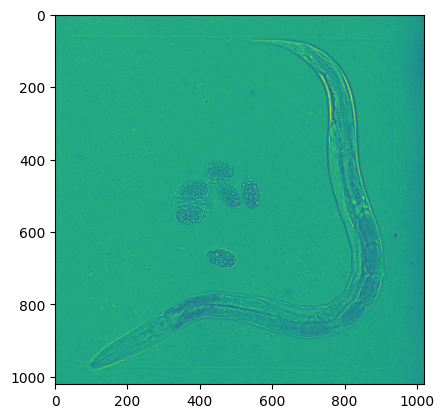

In [ ]:
from towbintools.foundation.zstack import find_best_plane
from utils.dataset import TilesDatasetFly, TilesDataset
from towbintools.deep_learning.utils.augmentation import get_mean_and_std, get_training_augmentation, get_validation_augmentation, grayscale_to_rgb, get_prediction_augmentation
import os
from time import perf_counter

import lightning.pytorch as pl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from joblib import Parallel, delayed
from pytorch_toolbelt import inference
import pytorch_toolbelt.losses as L


from skimage.filters import threshold_otsu
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard.writer import SummaryWriter
from torchmetrics.classification import BinaryF1Score
from torchvision.transforms import Compose, Normalize, ToTensor
from tqdm import tqdm
import albumentations as albu
from towbintools.foundation import image_handling
from utils.loss import FocalTverskyLoss

from architectures import NestedUNet
import pretrained_microscopy_models as pmm

preprocessing_fn = get_prediction_augmentation('percentile', lo=1, hi=99, RGB=False)

images_dir = "/mnt/towbin.data/shared/ngerber/20230927_LIPSI_20x_348_297_20C_20230927_165930_303"

def deep_learning_segmentation(image, model, device, preprocessing_fn, tiler, channels):
    image = preprocessing_fn(image=image)['image']

    tiles = tiler.split(image)
    tiles = [grayscale_to_rgb(tile) for tile in tiles]

    # assemble tiles into a batch
    batch = torch.stack(tiles)
    batch = batch.to(device)

    # predict

    prediction_tiles = []
    with torch.no_grad():
        prediction = model(batch)
    
    # assemble tiles into an image
    for pred_tile in prediction:
        pred_tile = pred_tile.cpu().numpy()
        pred_tile = np.moveaxis(pred_tile, 0, -1)
        prediction_tiles.append(pred_tile)
    
    pred = tiler.merge(prediction_tiles)
    mask = (pred > 0.5).astype(np.uint8)
    
    return mask


img_dir = "/mnt/towbin.data/shared/ngerber/20230927_LIPSI_20x_348_297_20C_20230927_165930_303/pad2/raw/"
images = sorted([os.path.join(img_dir, f) for f in os.listdir(img_dir)])

idx = 11910
print(images[idx])
test_img = image_handling.read_tiff_file(images[idx])
normal_test_img = test_img.copy()
print(test_img.shape)

test_img = augmentation(image=test_img)['image']

tiler = ImageSlicer(test_img.shape[2:], tile_size=(512, 512), tile_step=(256, 256), weight='pyramid')

plt.imshow(test_img[7, 2, ...])
plt.show()

In [ ]:
from towbintools.foundation.binary_image import get_biggest_object

total_mask = np.zeros((test_img.shape[0], test_img.shape[2], test_img.shape[3]), dtype=np.uint8)

for i,plane in enumerate(test_img):
    print(plane[0].shape)
    mask = deep_learning_segmentation(plane[2], model, torch.device('cpu'), preprocessing_fn, tiler, channels=[0]).squeeze()
    mask = get_biggest_object(mask)
    total_mask[i] = mask

(1021, 1020)
(1021, 1020)
(1021, 1020)
(1021, 1020)
(1021, 1020)
(1021, 1020)
(1021, 1020)
(1021, 1020)
(1021, 1020)
(1021, 1020)
(1021, 1020)
(1021, 1020)
(1021, 1020)
(1021, 1020)
(1021, 1020)
(1021, 1020)
(1021, 1020)


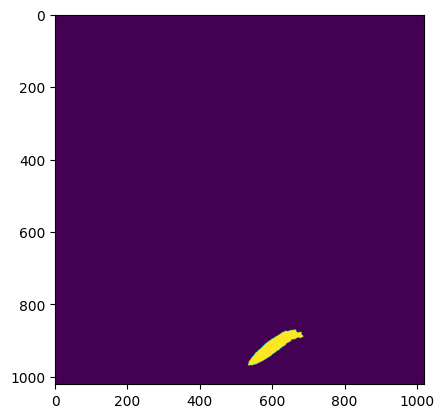

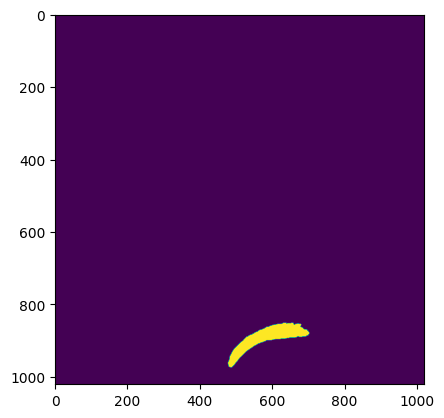

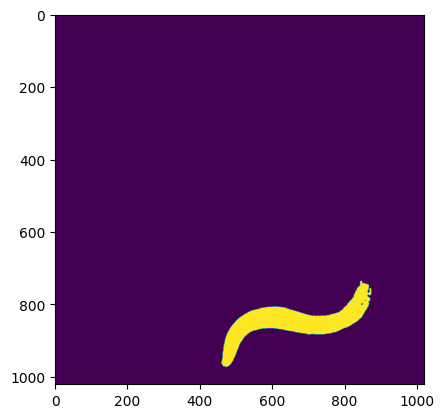

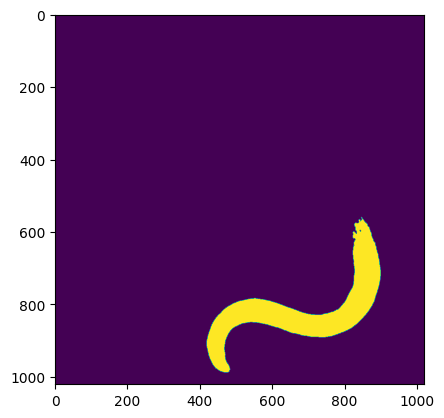

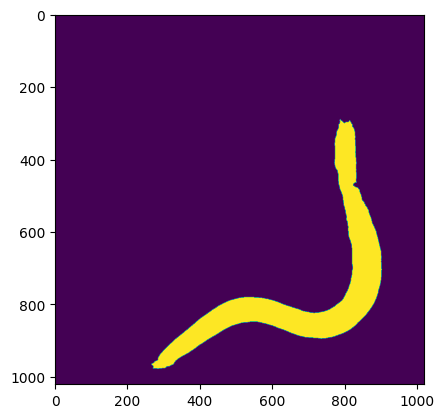

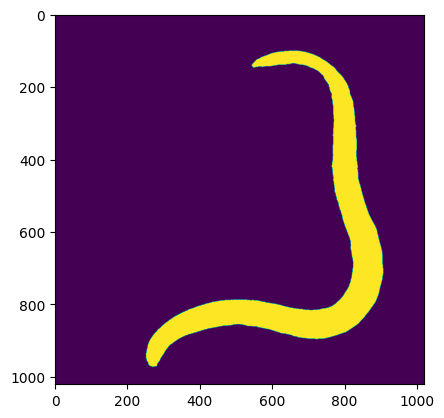

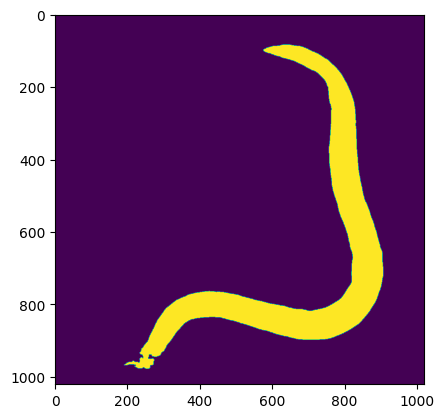

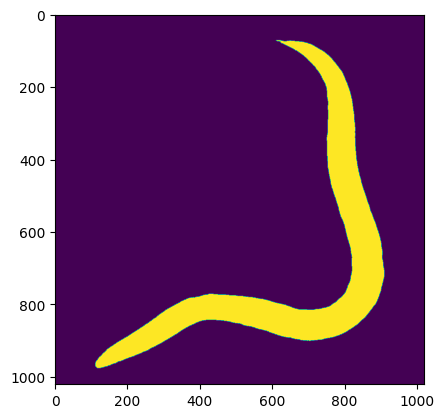

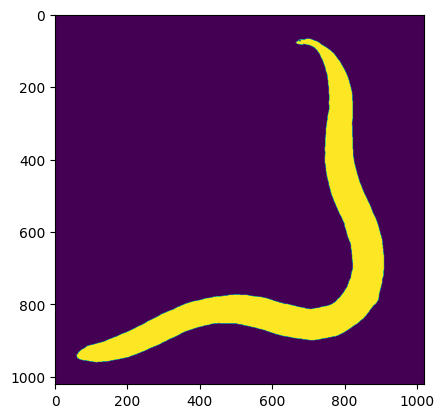

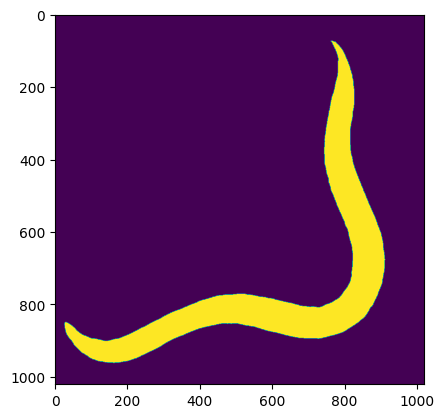

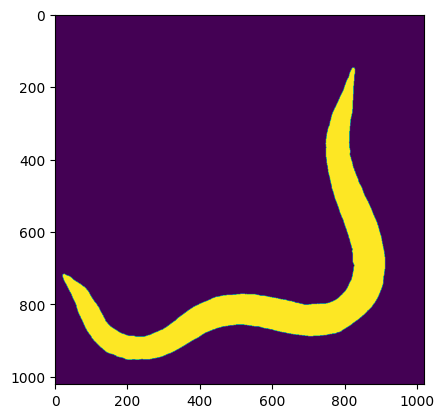

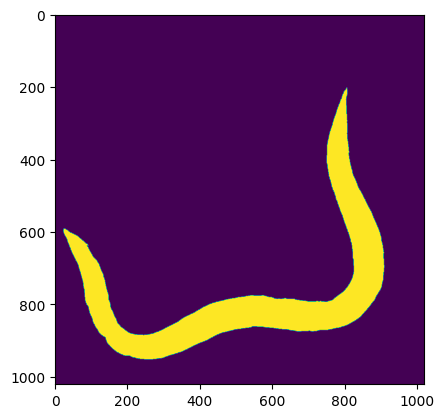

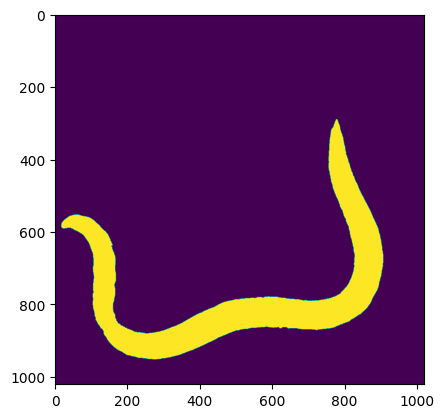

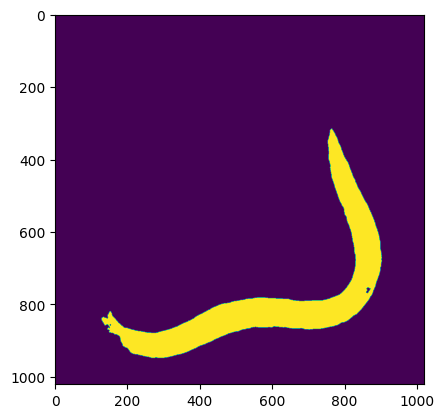

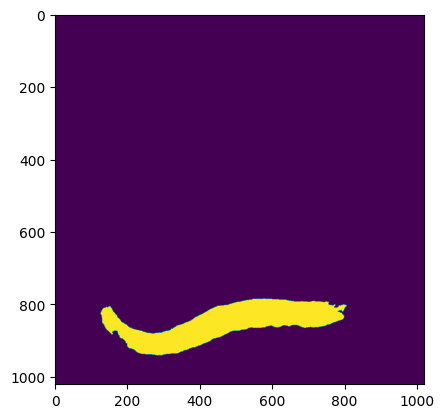

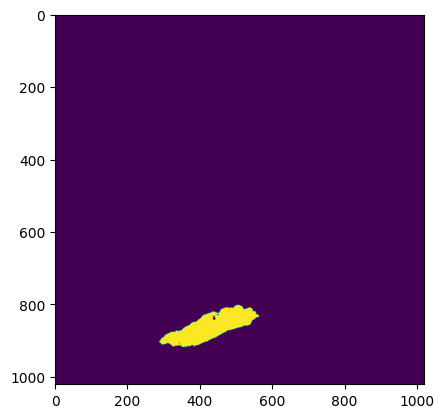

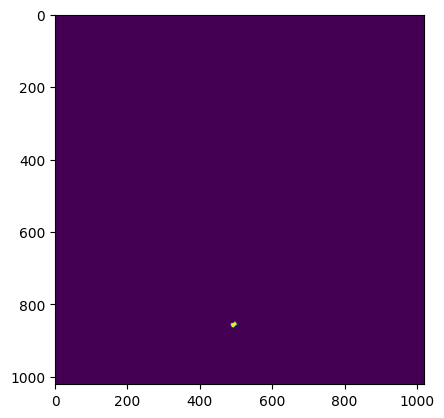

In [ ]:
for i, plane in enumerate(total_mask):
    plt.imshow(plane)
    plt.show()

In [ ]:
# find mean mask size for each plane
sum_mask = [np.sum(mask) for mask in total_mask]
# remove zeros
sum_mask = [s for s in sum_mask if s != 0]
mean_mask_size = np.mean(sum_mask)

# remove planes with masks that are too small to zero
for i, mask in enumerate(total_mask):
    if np.sum(mask) < mean_mask_size*0.9:
        total_mask[i] = np.zeros(mask.shape, dtype=np.uint8)

In [ ]:
from towbintools.straightening.straightening_tools import Warper
import cv2
# remove empty planes from total_mask and test_img
total_mask_cleaned = []
test_img_cleaned = []
for i, mask in enumerate(total_mask):
    mask = cv2.medianBlur(mask, 5)
    total_mask_cleaned.append(mask)
    test_img_cleaned.append(test_img[i])

total_mask_cleaned = np.array(total_mask_cleaned)
test_img_cleaned = np.array(normal_test_img)

warper = Warper.from_img(test_img_cleaned[:, 2, ...], total_mask_cleaned[:])

warped_img_ch2 = warper.warp_3D_img(test_img_cleaned[:, 1, ...], 1, preserve_range=True, preserve_dtype=np.uint16).astype(np.uint16)
print(f'max value of warped image: {np.max(warped_img_ch2)}')
warped_img_ch1 = warper.warp_3D_img(test_img_cleaned[:, 0, ...], 1, preserve_range=True, preserve_dtype=np.uint16).astype(np.uint16)

warped_img = np.stack([warped_img_ch1, warped_img_ch2], axis=1, dtype=np.uint16)
# warped_img = warper.warp_2D_img(normal_test_img[8, 1, ...],0)

# plt.imshow(warped_img)
# plt.show()

from tifffile import imwrite

imwrite("/home/spsalmon//warped_img.tif", warped_img, imagej=True, ome=True, compression='zlib')

max value of warped image: 692


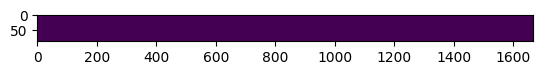

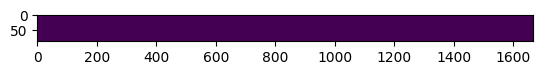

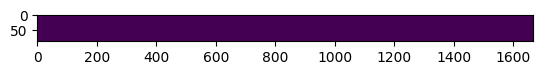

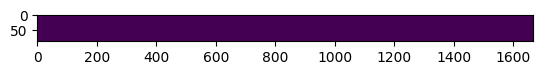

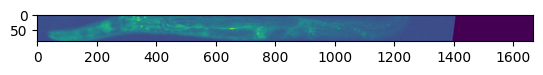

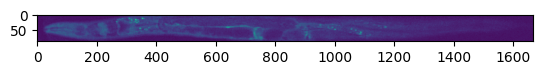

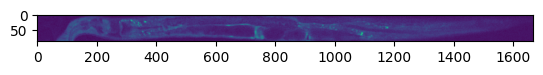

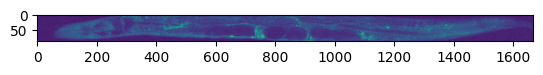

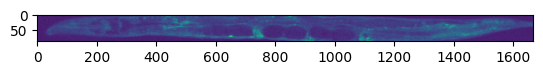

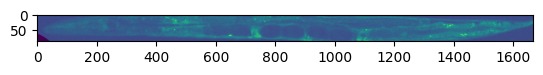

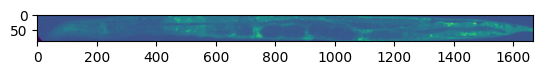

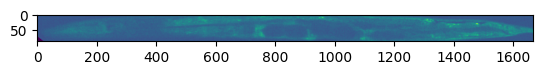

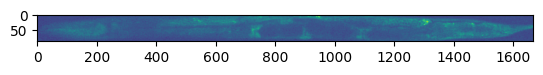

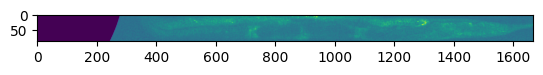

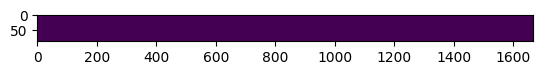

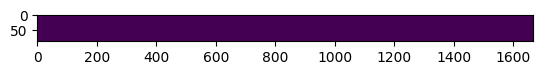

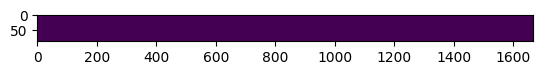

In [ ]:
for plane in warped_img:
    plt.imshow(plane[1])
    plt.show()